# node2vec
---
[node2vec](http://snap.stanford.edu/node2vec/) for link prediction:
1. Perform train-test split
1. Train skip-gram model on random walks within training graph
2. Get node embeddings from skip-gram model
3. Create bootstrapped edge embeddings by taking the Hadamard product of node embeddings
4. Train a logistic regression classifier on these edge embeddings (possible edge --> edge score between 0-1)
5. Evaluate these edge embeddings on the validation and test edge sets

node2vec source code: https://github.com/aditya-grover/node2vec

## 1. Read in Graph Data

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import scipy.sparse as sp
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score

In [2]:
EDGES_DIR = 'facebook/0.edges'

# Read edge-list
f = open(EDGES_DIR)
g_orig = nx.read_edgelist(f, nodetype=int)
g_adj = nx.to_numpy_matrix(g_orig) # convert to adjacency matrix (so node values become indices)
g = nx.from_numpy_matrix(g_adj) # re-create graph using node indices (0 to num_nodes-1)

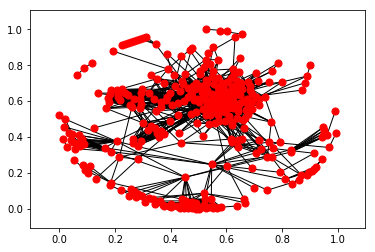

In [3]:
# draw network
nx.draw_networkx(g_orig, with_labels=False, node_size=50, node_color='r')
plt.show()

## 2. Preprocessing/Train-Test Split

In [17]:
from gae.preprocessing import mask_test_edges
np.random.seed(0) # make sure train-test split is consistent between notebooks
adj_sparse = nx.to_scipy_sparse_matrix(g)

# Perform train-test split
adj_train, train_edges, train_edges_false, val_edges, val_edges_false, \
    test_edges, test_edges_false = mask_test_edges(adj_sparse, test_frac=.3, val_frac=.1)
g_train = nx.from_scipy_sparse_matrix(adj_train) # new graph object with only non-hidden edges

In [5]:
# Inspect train/test split
print "Total nodes:", adj_sparse.shape[0]
print "Total edges:", int(adj_sparse.nnz/2) # adj is symmetric, so nnz (num non-zero) = 2*num_edges
print "Training edges (positive):", len(train_edges)
print "Training edges (negative):", len(train_edges_false)
print "Validation edges (positive):", len(val_edges)
print "Validation edges (negative):", len(val_edges_false)
print "Test edges (positive):", len(test_edges)
print "Test edges (negative):", len(test_edges_false)

Total nodes: 333
Total edges: 2519
Training edges (positive): 1513
Training edges (negative): 1513
Validation edges (positive): 251
Validation edges (negative): 251
Test edges (positive): 755
Test edges (negative): 755


## 3. Train node2vec (Learn Node Embeddings)

In [6]:
import node2vec
from gensim.models import Word2Vec

In [7]:
# node2vec settings
# NOTE: When p = q = 1, this is equivalent to DeepWalk

P = 1 # Return hyperparameter
Q = 1 # In-out hyperparameter
WINDOW_SIZE = 10 # Context size for optimization
NUM_WALKS = 10 # Number of walks per source
WALK_LENGTH = 80 # Length of walk per source
DIMENSIONS = 128 # Embedding dimension
DIRECTED = False # Graph directed/undirected
WORKERS = 8 # Num. parallel workers
ITER = 1 # SGD epochs

In [8]:
# Preprocessing, generate walks
g_n2v = node2vec.Graph(g_train, DIRECTED, P, Q) # create node2vec graph instance
g_n2v.preprocess_transition_probs()
walks = g_n2v.simulate_walks(NUM_WALKS, WALK_LENGTH)
walks = [map(str, walk) for walk in walks]

# Train skip-gram model
model = Word2Vec(walks, size=DIMENSIONS, window=WINDOW_SIZE, min_count=0, sg=1, workers=WORKERS, iter=ITER)

# Store embeddings mapping
emb_mappings = model.wv

Walk iteration:
1 / 10
2 / 10
3 / 10
4 / 10
5 / 10
6 / 10
7 / 10
8 / 10
9 / 10
10 / 10


## 4. Create Edge Embeddings

In [9]:
# Create node embeddings matrix (rows = nodes, columns = embedding features)
emb_list = []
for node_index in range(0, adj_sparse.shape[0]):
    node_str = str(node_index)
    node_emb = emb_mappings[node_str]
    emb_list.append(node_emb)
emb_matrix = np.vstack(emb_list)

In [10]:
# Generate bootstrapped edge embeddings (as is done in node2vec paper)
    # Edge embedding for (v1, v2) = hadamard product of node embeddings for v1, v2
def get_edge_embeddings(edge_list):
    embs = []
    for edge in edge_list:
        node1 = edge[0]
        node2 = edge[1]
        emb1 = emb_matrix[node1]
        emb2 = emb_matrix[node2]
        edge_emb = np.multiply(emb1, emb2)
        embs.append(edge_emb)
    embs = np.array(embs)
    return embs

In [11]:
# Train-set edge embeddings
pos_train_edge_embs = get_edge_embeddings(train_edges)
neg_train_edge_embs = get_edge_embeddings(train_edges_false)
train_edge_embs = np.concatenate([pos_train_edge_embs, neg_train_edge_embs])

# Create train-set edge labels: 1 = real edge, 0 = false edge
train_edge_labels = np.concatenate([np.ones(len(train_edges)), np.zeros(len(train_edges_false))])

# Val-set edge embeddings, labels
pos_val_edge_embs = get_edge_embeddings(val_edges)
neg_val_edge_embs = get_edge_embeddings(val_edges_false)
val_edge_embs = np.concatenate([pos_val_edge_embs, neg_val_edge_embs])
val_edge_labels = np.concatenate([np.ones(len(val_edges)), np.zeros(len(val_edges_false))])

# Test-set edge embeddings, labels
pos_test_edge_embs = get_edge_embeddings(test_edges)
neg_test_edge_embs = get_edge_embeddings(test_edges_false)
test_edge_embs = np.concatenate([pos_test_edge_embs, neg_test_edge_embs])

# Create val-set edge labels: 1 = real edge, 0 = false edge
test_edge_labels = np.concatenate([np.ones(len(test_edges)), np.zeros(len(test_edges_false))])

## 5. Evaluate Edge Embeddings

In [12]:
# Train logistic regression classifier on train-set edge embeddings
from sklearn.linear_model import LogisticRegression
edge_classifier = LogisticRegression(random_state=0)
edge_classifier.fit(train_edge_embs, train_edge_labels)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [13]:
# Predicted edge scores: probability of being of class "1" (real edge)
val_preds = edge_classifier.predict_proba(val_edge_embs)[:, 1]
val_roc = roc_auc_score(val_edge_labels, val_preds)
val_ap = average_precision_score(val_edge_labels, val_preds)

In [14]:
# Predicted edge scores: probability of being of class "1" (real edge)
test_preds = edge_classifier.predict_proba(test_edge_embs)[:, 1]
test_roc = roc_auc_score(test_edge_labels, test_preds)
test_ap = average_precision_score(test_edge_labels, test_preds)

In [15]:
print 'node2vec Validation ROC score: ', str(val_roc)
print 'node2vec Validation AP score: ', str(val_ap)
print 'node2vec Test ROC score: ', str(test_roc)
print 'node2vec Test AP score: ', str(test_ap)

node2vec Validation ROC score:  0.907009412549
node2vec Validation AP score:  0.897788231212
node2vec Test ROC score:  0.884709442568
node2vec Test AP score:  0.831784597727
